## Hồi quy tuyến tính và hồi quy đa thức để định giá bí ngô - Bài học 3

Tải các thư viện cần thiết và tập dữ liệu. Chuyển đổi dữ liệu thành một dataframe chứa một phần dữ liệu:

- Chỉ lấy bí ngô được định giá theo đơn vị bushel
- Chuyển đổi ngày thành tháng
- Tính giá trung bình dựa trên giá cao và giá thấp
- Chuyển đổi giá để phản ánh mức giá theo số lượng bushel


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Biểu đồ phân tán nhắc nhở chúng ta rằng chúng ta chỉ có dữ liệu tháng từ tháng Tám đến tháng Mười Hai. Chúng ta có lẽ cần thêm dữ liệu để có thể đưa ra kết luận theo cách tuyến tính.


<AxesSubplot:xlabel='Month', ylabel='Price'>

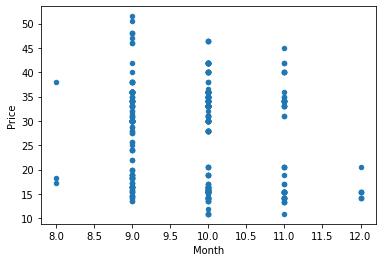

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

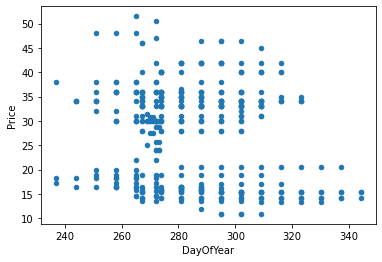

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Có vẻ như mối tương quan khá nhỏ, nhưng có một mối quan hệ quan trọng hơn - vì các điểm giá trong biểu đồ trên dường như có một số cụm riêng biệt. Hãy tạo một biểu đồ để hiển thị các loại bí ngô khác nhau:


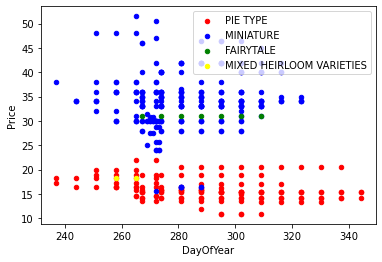

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

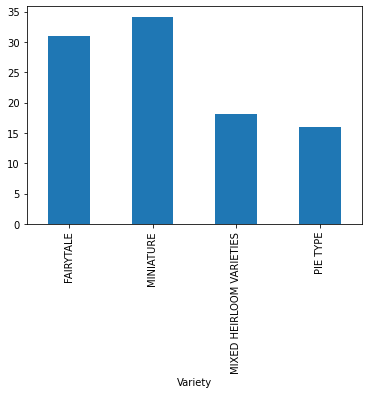

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

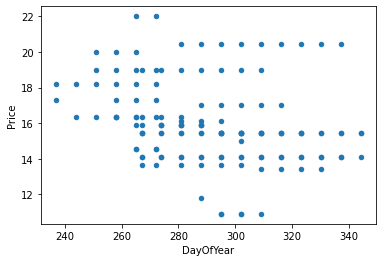

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Hồi quy tuyến tính

Chúng ta sẽ sử dụng Scikit Learn để huấn luyện mô hình hồi quy tuyến tính:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


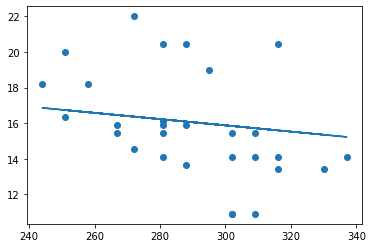

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Độ dốc của đường thẳng có thể được xác định từ các hệ số hồi quy tuyến tính:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Hồi quy đa thức

Đôi khi mối quan hệ giữa các đặc điểm và kết quả vốn dĩ không tuyến tính. Ví dụ, giá bí ngô có thể cao vào mùa đông (tháng 1, 2), sau đó giảm vào mùa hè (tháng 5-7), rồi lại tăng lên. Hồi quy tuyến tính không thể tìm ra mối quan hệ này một cách chính xác.

Trong trường hợp này, chúng ta có thể cân nhắc thêm các đặc điểm bổ sung. Một cách đơn giản là sử dụng các đa thức từ các đặc điểm đầu vào, điều này sẽ dẫn đến **hồi quy đa thức**. Trong Scikit Learn, chúng ta có thể tự động tính trước các đặc điểm đa thức bằng cách sử dụng pipelines:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


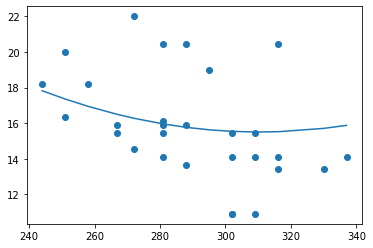

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Các phương pháp mã hóa

Trong thế giới lý tưởng, chúng ta muốn có thể dự đoán giá cho các loại bí ngô khác nhau bằng cùng một mô hình. Để tính đến loại bí ngô, trước tiên chúng ta cần chuyển đổi nó sang dạng số, hay còn gọi là **mã hóa**. Có một số cách để thực hiện điều này:

* Mã hóa số đơn giản sẽ tạo một bảng các loại khác nhau, sau đó thay thế tên loại bằng một chỉ số trong bảng đó. Đây không phải là ý tưởng tốt nhất cho hồi quy tuyến tính, vì hồi quy tuyến tính sẽ tính đến giá trị số của chỉ số, và giá trị số này có khả năng không tương quan một cách tuyến tính với giá cả.
* Mã hóa one-hot, sẽ thay thế cột `Variety` bằng 4 cột khác nhau, mỗi cột đại diện cho một loại, chứa giá trị 1 nếu hàng tương ứng thuộc loại đó, và 0 nếu không.

Đoạn mã dưới đây cho thấy cách chúng ta có thể mã hóa one-hot cho một loại:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Hồi quy tuyến tính trên các loại

Bây giờ chúng ta sẽ sử dụng cùng một đoạn mã như trên, nhưng thay vì `DayOfYear`, chúng ta sẽ sử dụng loại đã được mã hóa one-hot làm đầu vào:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Chúng ta cũng có thể thử sử dụng các đặc điểm khác theo cách tương tự, và kết hợp chúng với các đặc điểm số, chẳng hạn như `Month` hoặc `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Hồi quy đa thức

Hồi quy đa thức cũng có thể được sử dụng với các đặc trưng phân loại đã được mã hóa one-hot. Mã nguồn để huấn luyện hồi quy đa thức về cơ bản sẽ giống như chúng ta đã thấy ở trên.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn tham khảo chính thức. Đối với các thông tin quan trọng, chúng tôi khuyến nghị sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
